In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt

###PLEASE MODIFY THIS PATH WHEN USING THIS PROGRAM###
File = open(r'C:\users\Jiashuo Tong\Desktop\PA4\Mesh-Sixteen-Elements.m')
Lines = File.readlines()

#Function for reading the nodes info into a list
def read_nodes(lines):
    nodes = []
    while lines[0][0] == "%":
        lines.pop(0)
    
    index = 0
    while lines[0][0] != "%":
        nodes.insert(index, extract_coordinates(lines[0]))
        lines.pop(0)
        index += 1;
    return [-1] + nodes

#Helper function which extract coordinates from a line
def extract_coordinates(line):
    coordinates = [float(s) for s in line.split() if is_number(s)][1:3]
    return coordinates

#Helper function which determines whether a string represents a floating point number
def is_number(n):
    try:
        float(n)
    except ValueError:
        return False
    return True

#Function for reading the elements info into a list
def read_elements(lines):
    elements = []
    while lines[0][0] == "%":
        lines.pop(0)
    
    index = 0
    while lines[0][0] != "%":
        elements.insert(index, extract_element(lines[0]))
        lines.pop(0)
        index += 1;
    return [-1] + elements

#Helper function which extract elements from a line
def extract_element(line):
    element = [int(s) for s in line.split() if is_number(s)][1:]
    return element


#Function for reading the BC's info into a list
def read_BCs(lines):
    BCs = []
    while lines[0][0] == "%":
        lines.pop(0)
    
    index = 0
    for i in lines:

        BCs.insert(index, extract_BC(i))
        index += 1
    return BCs

#Helper function which extract BCs from a line
def extract_BC(line):
    BC = [float(s) for s in line.split() if is_number(s)][1:3]
    return BC

#Function for building K matrix
def build_KF(nodes, elements):
    size = len(nodes)-1
    K = np.zeros((size, size))
    F = np.zeros(size)
    #Update the K matrix element by element
    for i in range(1, len(elements)):
        node_list = elements[i]
        local_nodes = [Nodes[j] for j in node_list]
        K, F = update_KF(K, F, local_nodes, node_list)
    return K, F

#Helper function to add Ke to K, Fe to F
def update_KF(K, F, localNodes, nodeList):
    #Define shape functions to use
    xi = Symbol('xi')
    eta = Symbol('eta')
    N1 = (1-xi)*(1-eta)/4
    N2 = (1+xi)*(1-eta)/4
    N3 = (1+xi)*(1+eta)/4
    N4 = (1-xi)*(1+eta)/4
    N = [N1, N2, N3, N4]
    #Compute x_xi, y_xi, x_eta, y_eta
    x_xi, y_xi, x_eta, y_eta = 0, 0, 0, 0
    for a in range(0,4):
        x_xi += N[a].diff(xi)*localNodes[a][0]
        x_eta += N[a].diff(eta)*localNodes[a][0]
        y_xi += N[a].diff(xi)*localNodes[a][1]
        y_eta += N[a].diff(eta)*localNodes[a][1]
    #Compute Jacobian
    J = x_xi*y_eta-x_eta*y_xi
    #Compute xi_x, xi_y, eta_x, eta_y
    xi_x, xi_y, eta_x, eta_y = y_eta/J, -x_eta/J, -y_xi/J, x_xi/J
    #Compute the 16 entries of Ke and add them to K
    for a in range(0,4):
        for b in range(0,4):
            Na_x = N[a].diff(xi)*xi_x+N[a].diff(eta)*eta_x
            Nb_x = N[b].diff(xi)*xi_x+N[b].diff(eta)*eta_x
            Na_y = N[a].diff(xi)*xi_y+N[a].diff(eta)*eta_y
            Nb_y = N[b].diff(xi)*xi_y+N[b].diff(eta)*eta_y
            integrand = Na_x*Nb_x + Na_y*Nb_y
            K[nodeList[a]-1][nodeList[b]-1] += integrate(integrate(integrand,(xi,-1,1)),(eta,-1,1))*J
        #Compute the 4 entries of Fe and add them to F
        F[nodeList[a]-1] += -4*integrate(integrate(N[a],(xi,-1,1)),(eta,-1,1))*J
    return K, F

#Function for imposing Boundary Conditions to K & F
def impose_BCs(K, F, BCs):
    size = len(F)
    for i in range(0,size):
        if BCs[i][0]> 0:
            for j in range(0,size):
                F[j] = F[j] - K[j][i]*BCs[i][1]
            K[i,:] = np.zeros(size)
            K[:,i] = np.zeros(size)
            K[i][i] = 1
            F[i] = BCs[i][1]     
    return K, F


#------------------------MAIN CODES-----------------------------#
#Read nodes, elemments and BCs read from .m file
Nodes = read_nodes(Lines)
Elements = read_elements(Lines)
BCs = read_BCs(Lines)

#print('Nodes: ', Nodes)
#print('Elements: ', Elements)
print('BCs: ', BCs)

#Build K matrix and F vector from nodes and elements
K, F = build_KF(Nodes, Elements)
#Impose Boundary Conditions on K and F
K, F = impose_BCs(K, F, BCs)
#Compute the solution vector by d = K_inv x F
d = np.linalg.inv(K) @ F

#print('K: ', K)
#print('F: ', F)
print('The solution vector d is ', d)

BCs:  [[1.0, 0.0], [1.0, 0.0625], [1.0, 0.25], [1.0, 0.5625], [1.0, 1.0], [1.0, 0.0625], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [1.0, 1.0625], [1.0, 0.25], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [1.0, 1.25], [1.0, 0.5625], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [1.0, 1.5625], [1.0, 1.0], [1.0, 1.0625], [1.0, 1.25], [1.0, 1.5625], [1.0, 2.0]]
The solution vector d is  [0.     0.0625 0.25   0.5625 1.     0.0625 0.125  0.3125 0.625  1.0625
 0.25   0.3125 0.5    0.8125 1.25   0.5625 0.625  0.8125 1.125  1.5625
 1.     1.0625 1.25   1.5625 2.    ]


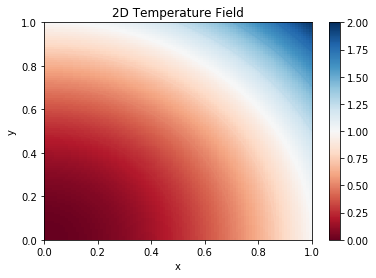

In [16]:
#For Plotting 2D Color Map
import matplotlib
import matplotlib.pyplot as plt

def f(x, y):
    return x**2+y**2
x_values = np.linspace(0,1,100)
y_values = np.linspace(0,1,100)
X, Y = np.meshgrid(x_values, y_values)
Z = f(X,Y)

fig, ax = plt.subplots()
p = ax.pcolor(X, Y, Z, cmap=matplotlib.cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max())
cb = fig.colorbar(p, ax=ax)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('2D Temperature Field Map')

#Plotting the Function in 3D
cnt = ax.contour(Z, cmap=matplotlib.cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max(), extent=[0, 1, 0, 1])

Text(0.5, 1.0, '2D Temperature Contour Map')

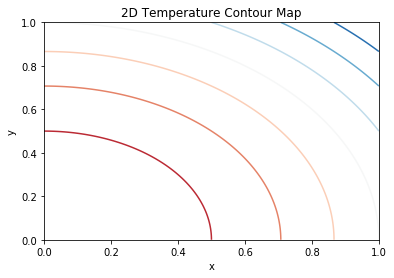

In [26]:
fig, ax = plt.subplots()

cnt = ax.contour(Z, cmap=matplotlib.cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max(), extent=[0, 1, 0, 1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('2D Temperature Contour Map')

Text(0.5, 0.92, '3D Plot of Temperature Field')

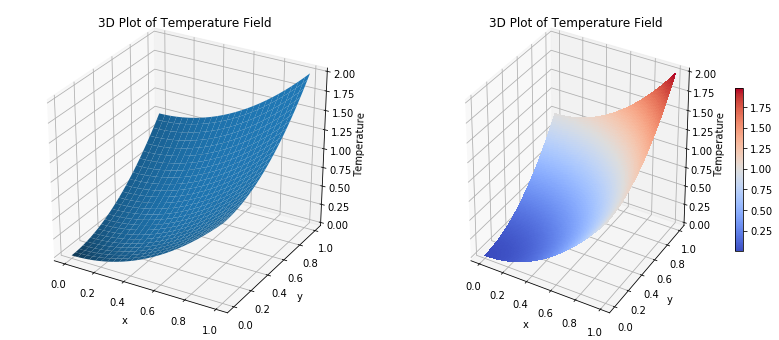

In [25]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig = plt.figure(figsize=(14,6))

# `ax` is a 3D-aware axis instance because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride=4, cstride=4, linewidth=0)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Temperature')
ax.set_title('3D Plot of Temperature Field')


# surface_plot with color grading and color bar
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Temperature')
ax.set_title('3D Plot of Temperature Field')